# Text Analisis - \#NuevasEleccionesPeru

In [2]:
import warnings
warnings.filterwarnings("ignore")
#evitamos los warnings

#Import libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import string 
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import json
import re
import requests

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
path = "/dataset/"
excel_path = f"{path}data/"

In [5]:
import os

dfs = [pd.read_excel(excel_path + p) for p in os.listdir(excel_path)]
dataset = pd.concat(dfs)

display(dataset.sort_index().head(5))
print('\n Hay {} observaciones con {} características'.format(*dataset.shape))

,Unnamed: 0,user_name,user_id,tweet,tweet_id,reply_id,created_at,favourite_count,retweet_count,location
0,0,Justakindofsad,763481767558995968,Keiko pide #NuevasEleccionesPeru\nTantos compr...,1404589459891535872,NaN,2021-06-14 23:59:57,0,377,Room
1,1,Glamourocita,33596720,Con peritaje!! Incluido ! \n#NuevasEleccionesP...,1404589453956502016,NaN,2021-06-14 23:59:56,0,571,México
2,2,Rubn12485642,1325763027480834048,@JBCPERU @reyconbarba #NuevasEleccionesPeru y ...,1404589452316525056,NaN,2021-06-14 23:59:56,0,70,NaN
3,3,PepitaPaquita,887133748810190848,"#NuevasEleccionesPeru Lo justo, para que no qu...",1404589431730885120,NaN,2021-06-14 23:59:51,0,0,Peru
4,4,Justakindofsad,763481767558995968,"Sin pruebas, sin hechos solamente con el ejerc...",1404589380011015936,NaN,2021-06-14 23:59:38,0,210,Room



 Hay 8912 observaciones con 10 características


In [6]:
add_stop_words = ["rt", "si", "va", "ve", "don"]


def get_words(text_content):
    """ Function to get words from text content

        @param text_content    The text content
    """  
    text_in_lower = str(text_content).replace('\n', ' ').replace("\t", " ").lower()

    emojiToText = emoji.replace_emoji(text_in_lower)

    only_text = re.sub(r'(#[A-Za-z0-9_]+)|(.#[A-Za-z0-9_]+)|(@[A-Za-z0-9_]+)|(.@[A-Za-z0-9_]+)|(http\S+)|([^a-záéíóúñ ]+)', ' ', emojiToText)

    return only_text.split()


def processing_words(text_content):
    """ Function to processing words from text content

        @param text_content    The text content
    """

    words = get_words(text_content)

    spanish_stops = set(stopwords.words('spanish') + add_stop_words )

    return " ".join([word for word in words if word not in spanish_stops and len(word) > 3])

def preprocess_dataset(dataset):
  preprocessed_dataset = dataset.copy().dropna()
  
  preprocessed_dataset.drop_duplicates(['Tweet'], keep='first', inplace=True)

  label_encoder = LabelEncoder()

  preprocessed_dataset["Y"] = label_encoder.fit_transform(preprocessed_dataset["Y"].astype(str))
  labels = dict(enumerate(label_encoder.classes_))

  print("Para la columna '{}', la codificación fue: {}".format("Y", labels))

  return preprocessed_dataset, labels

class EmojiDecode():

  def __init__(self, emoji_path):
    emoji_file = requests.get(emoji_path)
    self.emojis = json.loads(emoji_file.text)

  def multiple_replace(self, di, text):
    regex = re.compile("(%s)" % "|".join(map(re.escape, di.keys())))

    return regex.sub(lambda mo: di[mo.string[mo.start():mo.end()]], text) 

  def filter_emojis(self, by_replace):
    return {i : self.emojis[i] for i in by_replace if i in self.emojis.keys()}    

  def replace_emoji(self, text):
    by_replace = list(set(re.findall(r'[^\w\s,]', text)))
    if not by_replace:
      return text

    emojis = self.filter_emojis(by_replace)
    if not emojis:
      return text

    return self.multiple_replace(emojis, text)    

emoji = EmojiDecode('https://github.com/AnthonyWainer/NuevasEleccionesPeru2021/blob/main/dataset/emoticones.json?raw=true')

In [7]:
dataset.loc[:, ('clean_tweet')] = dataset.tweet.apply(processing_words)

In [8]:
dataset.sort_index(inplace=True)

dataset.head(10)

,Unnamed: 0,user_name,user_id,tweet,tweet_id,reply_id,created_at,favourite_count,retweet_count,location,clean_tweet
0,0,Justakindofsad,763481767558995968,Keiko pide #NuevasEleccionesPeru\nTantos compr...,1404589459891535872,NaN,2021-06-14 23:59:57,0,377,Room,keiko pide tantos compromisos firmados engaño
1,1,Glamourocita,33596720,Con peritaje!! Incluido ! \n#NuevasEleccionesP...,1404589453956502016,NaN,2021-06-14 23:59:56,0,571,México,peritaje incluido
2,2,Rubn12485642,1325763027480834048,@JBCPERU @reyconbarba #NuevasEleccionesPeru y ...,1404589452316525056,NaN,2021-06-14 23:59:56,0,70,NaN,pruebas presentadas permita participar partido...
3,3,PepitaPaquita,887133748810190848,"#NuevasEleccionesPeru Lo justo, para que no qu...",1404589431730885120,NaN,2021-06-14 23:59:51,0,0,Peru,justo queden dudas
4,4,Justakindofsad,763481767558995968,"Sin pruebas, sin hechos solamente con el ejerc...",1404589380011015936,NaN,2021-06-14 23:59:38,0,210,Room,pruebas hechos solamente ejercicio prepotencia...
5,5,Fatima18641859,1325996212139462912,tu vieja\n#NuevasEleccionesPeru\nhttps://t.co/...,1404589373690102016,NaN,2021-06-14 23:59:37,0,1,NaN,vieja
6,6,ximetarazona1,785296521159999488,"KEIKO FUJIMORI pasará a la historia del Perú, ...",1404589367100854016,NaN,2021-06-14 23:59:35,0,288,"Lima, Peru",keiko fujimori pasará historia perú grande per...
7,7,LizGodoyCh,890972282499325952,"#NuevasEleccionesPeru = GOLPE DE ESTADO, en co...",1404589365876122112,NaN,2021-06-14 23:59:35,0,83,"Lima, Peru",golpe complicidad medios comunicación mario al...
8,8,Justakindofsad,763481767558995968,"#NuevasEleccionesPeru significa golpe, signif...",1404589340924256000,NaN,2021-06-14 23:59:29,0,378,Room,significa golpe significa peso organizaciones ...
9,9,LeslySarayasi,2561322989,"#NuevasEleccionesPeru significa golpe, signif...",1404589321252975104,NaN,2021-06-14 23:59:24,0,378,"Lima, Peru",significa golpe significa peso organizaciones ...


Text(0.5, 1.0, 'Palabras más frecuentes - Top 30')

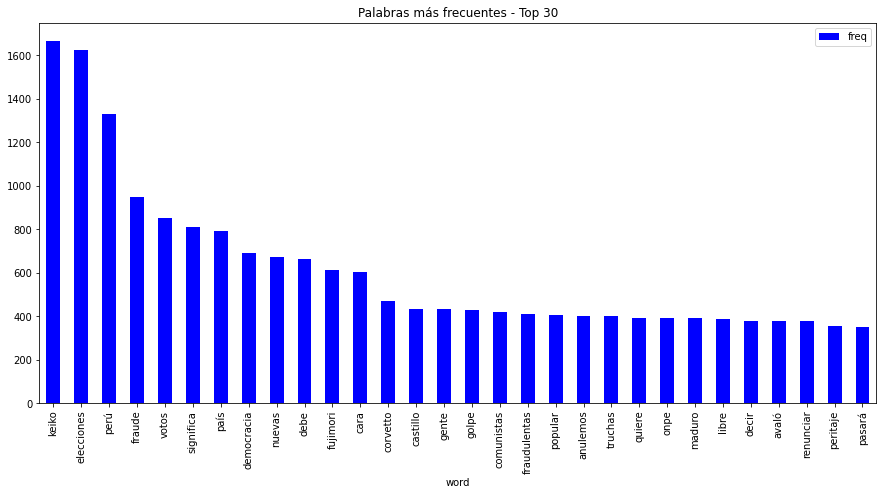

In [143]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

words = cv.fit_transform(dataset.clean_tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')

plt.title("Palabras más frecuentes - Top 30")

Text(0.5, 1.0, 'WordCloud')

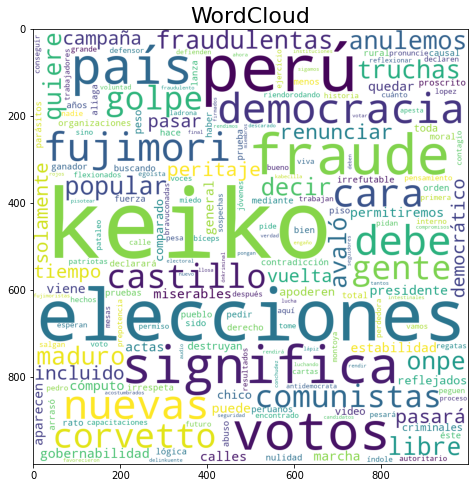

In [144]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud", fontsize = 22)

# IDF

In [57]:
vectorizer = TfidfVectorizer(max_features=100, dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)

data = dataset.clean_tweet.values.tolist()

FV = vectorizer.fit_transform(data)
FV = FV.toarray()

In [52]:
data[0]

'keiko pide tantos compromisos firmados engaño'

In [59]:
scaler = StandardScaler()  
scaler.fit(FV.tolist())
X1 = scaler.transform(FV.tolist())

In [62]:
np.asarray(X1).shape

(8912, 100)

In [60]:
len(np.asarray(X1))

8912

In [65]:
np.asarray(X1)[0]

array([-0.17023656, -0.17129231, -0.16136432, -0.21762724, -0.17877148,
       -0.17877148, -0.17023656, -0.20986793, -0.15101144, -0.16289336,
       -0.1691136 , -0.16870852, -0.17666131, -0.15722967, -0.23592733,
       -0.20798681, -0.15780193, -0.17877148, -0.17877148, -0.17684774,
       -0.17023656, -0.23079717, -0.17609061, -0.17873279, -0.27829741,
       -0.20605302, -0.17023656, -0.27382644, -0.17218479, -0.16264439,
       -0.17877148, -0.39507004, -0.17918644, -0.32172263, -0.21900134,
       -0.15906221, -0.24299167, -0.16675458, -0.17779183, -0.19611284,
       -0.18492872, -0.18876952, -0.15467199, -0.15299248, -0.19915828,
       -0.15780193, -0.17023656,  4.84262728, -0.17023656, -0.18882764,
       -0.17023656, -0.2136741 , -0.16833291, -0.16719059, -0.16073707,
       -0.17879891, -0.17023656, -0.2543061 , -0.16360509, -0.20963659,
       -0.17660295, -0.17629074, -0.15702152, -0.17926684, -0.20217499,
       -0.28190561, -0.15183188, -0.20302909, -0.17785965, -0.16

In [68]:
dataset['FV'] = FV.tolist()
dataset.head(10)

,Unnamed: 0,user_name,user_id,tweet,tweet_id,reply_id,created_at,favourite_count,retweet_count,location,clean_tweet,FV
0,0,Justakindofsad,763481767558995968,Keiko pide #NuevasEleccionesPeru\nTantos compr...,1404589459891535872,NaN,2021-06-14 23:59:57,0,377,Room,keiko pide tantos compromisos firmados engaño,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,Glamourocita,33596720,Con peritaje!! Incluido ! \n#NuevasEleccionesP...,1404589453956502016,NaN,2021-06-14 23:59:56,0,571,México,peritaje incluido,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,Rubn12485642,1325763027480834048,@JBCPERU @reyconbarba #NuevasEleccionesPeru y ...,1404589452316525056,NaN,2021-06-14 23:59:56,0,70,NaN,pruebas presentadas permita participar partido...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,PepitaPaquita,887133748810190848,"#NuevasEleccionesPeru Lo justo, para que no qu...",1404589431730885120,NaN,2021-06-14 23:59:51,0,0,Peru,justo queden dudas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,Justakindofsad,763481767558995968,"Sin pruebas, sin hechos solamente con el ejerc...",1404589380011015936,NaN,2021-06-14 23:59:38,0,210,Room,pruebas hechos solamente ejercicio prepotencia...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,5,Fatima18641859,1325996212139462912,tu vieja\n#NuevasEleccionesPeru\nhttps://t.co/...,1404589373690102016,NaN,2021-06-14 23:59:37,0,1,NaN,vieja,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,6,ximetarazona1,785296521159999488,"KEIKO FUJIMORI pasará a la historia del Perú, ...",1404589367100854016,NaN,2021-06-14 23:59:35,0,288,"Lima, Peru",keiko fujimori pasará historia perú grande per...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.409..."
7,7,LizGodoyCh,890972282499325952,"#NuevasEleccionesPeru = GOLPE DE ESTADO, en co...",1404589365876122112,NaN,2021-06-14 23:59:35,0,83,"Lima, Peru",golpe complicidad medios comunicación mario al...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,8,Justakindofsad,763481767558995968,"#NuevasEleccionesPeru significa golpe, signif...",1404589340924256000,NaN,2021-06-14 23:59:29,0,378,Room,significa golpe significa peso organizaciones ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,9,LeslySarayasi,2561322989,"#NuevasEleccionesPeru significa golpe, signif...",1404589321252975104,NaN,2021-06-14 23:59:24,0,378,"Lima, Peru",significa golpe significa peso organizaciones ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# K-MEANS

In [71]:
from sklearn.cluster import KMeans

#Creando modelo clusters asignados
def CrearKMeans(k, vectors):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(vectors)
    lb_km = kmeans.labels_
    return lb_km, kmeans

In [72]:
labels, modelo = CrearKMeans(5, X1)

In [74]:
import collections

def e_x_cluster(lb_km):
    e_clus = collections.Counter(lb_km)
    cant_x_cl = pd.DataFrame.from_dict(e_clus, orient = 'index')
    cant_x_cl.rename(columns={0:'Cantidad_elementos'}, inplace=True)
    cant_x_cl = cant_x_cl.sort_index(axis=0)
    return cant_x_cl

cant_x_cluster = e_x_cluster(labels)

cant_x_cluster

,Cantidad_elementos
0,7897
1,270
2,218
3,251
4,276


In [96]:
from wordcloud import WordCloud, ImageColorGenerator

In [76]:
cluster_df = pd.DataFrame({"tweets":data,
            "cluster": labels}) 
cluster_df.head()

,tweets,cluster
0,keiko pide tantos compromisos firmados engaño,0
1,peritaje incluido,0
2,pruebas presentadas permita participar partido...,0
3,justo queden dudas,0
4,pruebas hechos solamente ejercicio prepotencia...,0


In [118]:
cluster_df.head()

,tweets,cluster
0,keiko pide tantos compromisos firmados engaño,0
1,peritaje incluido,0
2,pruebas presentadas permita participar partido...,0
3,justo queden dudas,0
4,pruebas hechos solamente ejercicio prepotencia...,0


In [87]:
#Frecuencia de palabras por cluster
def cant_palabras_clust(vec_etiqueta, i):
    vec_coments = vec_etiqueta[vec_etiqueta['cluster'] == i]
    coms_k_i = vec_coments['tweets'].tolist()
    coms_k_i = str(coms_k_i)
    #coms_k_i = re.sub('[^A-Za-z0-9]+', ' ', coms_k_i)
    pal_k_i = collections.Counter(coms_k_i.split())
    df_pal_k_i = pd.DataFrame.from_dict(pal_k_i, orient = 'index')
    df_pal_k_i.rename(columns={0:'freq_pal'}, inplace=True)
    df_pal_k_i = df_pal_k_i.sort_values('freq_pal',ascending=False)
    
    return df_pal_k_i 

In [88]:
def cont_x_clus(x_clus):
    palabras_cl = []
    cnt_labels = len(set(labels))
    for i in range (cnt_labels):
        palabras_cl.append(cant_palabras_clust(x_clus,i))
    return palabras_cl

In [89]:
palabrasx_cls = cont_x_clus(cluster_df)

palabrasx_cls[0].head()

,freq_pal
elecciones,1222
keiko,1003
fraude,740
debe,660
perú,599


In [106]:
def word_cloud(pl_x_cl,i):
    dict_p=pl_x_cl[i].to_dict()
    wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110)
    wordcloud.generate_from_frequencies(frequencies=dict_p['freq_pal'])
    plt.figure(figsize=(10, 7))
    plt.title('Cluster ['+str(i)+"] : "+pl_x_cl[i].index[0]+" "+pl_x_cl[i].index[1]+" "+pl_x_cl[i].index[2]+" "+pl_x_cl[i].index[3]+" "+pl_x_cl[i].index[4]+" "+pl_x_cl[i].index[5])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    return wordcloud

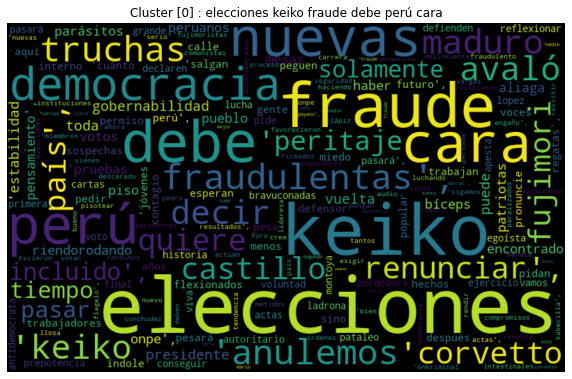

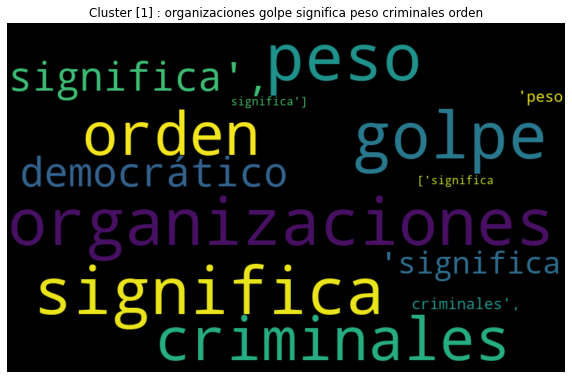

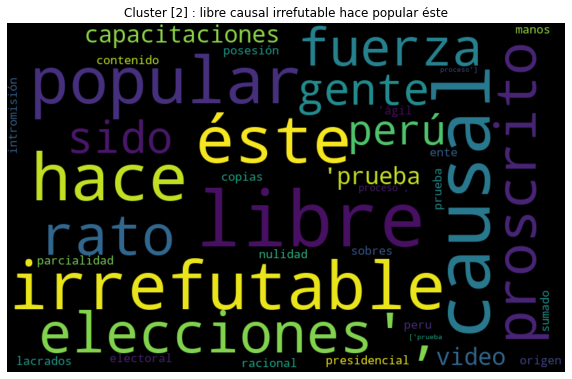

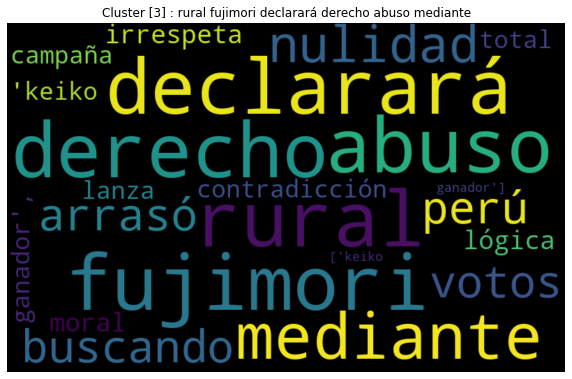

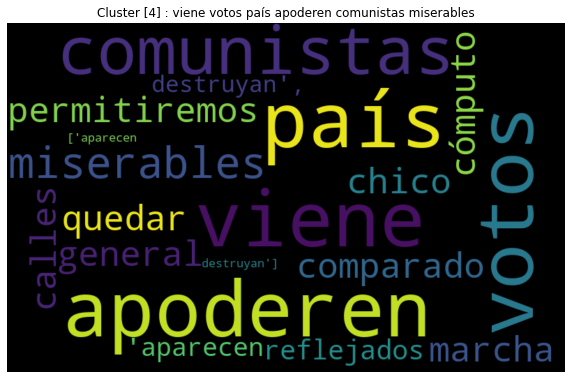

In [109]:
nubes = []
cnt_labels = len(set(labels))
for i in range(0, cnt_labels):
    try:
        nubes.append(word_cloud(palabrasx_cls, i))
    except Exception as error:
        print(error)
        continue 

In [ ]:
new_dataset.to_excel(f"{path}test.xlsx")

In [ ]:
final_dataset.to_excel(f"{path}politica_etiquetado.xlsx")